In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display

In [2]:
df_combined = pd.read_csv('data/2022-2024_Stats.csv')

# Model Training

## Let users choose between Weekly or Monthly

In [3]:
# Define button options and their corresponding parameters
button_options = {
    "Weekly": {"train_days": df_combined[-90:-30], "num_steps": 7, "p": 7, "d": 1, "q": 2,
               "start_date": pd.Timestamp('2024-02-25'), "td_days": 6},
    "Monthly": {"train_days": df_combined[-130:-30], "num_steps": 30, "p": 7, "d": 1, "q": 1,
               "start_date": pd.Timestamp('2024-02-25'), "td_days": 29}
}

# Define a function to handle button clicks
def on_button_clicked(b):
    global clicked_button, train_days, num_steps, p, d, q, start_date, end_date
    clicked_button = b.description
    print("Button clicked:", clicked_button)

    # Update parameters based on the clicked button
    parameters = button_options.get(clicked_button)
    if parameters:
        train_days = parameters["train_days"]
        num_steps = parameters["num_steps"]
        p, d, q = parameters["p"], parameters["d"], parameters["q"]
        start_date = parameters["start_date"].date()
        td_days = parameters["td_days"]
        end_date = start_date + timedelta(days=td_days)
        print(len(train_days), num_steps, p, d, q, start_date, end_date, td_days)

# Create buttons
buttons = [widgets.Button(description=option) for option in button_options]

# Assign callbacks to buttons
for button in buttons:
    button.on_click(on_button_clicked)

# Display buttons
display(*buttons)


Button(description='Weekly', style=ButtonStyle())

Button(description='Monthly', style=ButtonStyle())

Button clicked: Weekly
60 7 7 1 2 2024-02-25 2024-03-02 6


## Predict based on whether Weekly or Monthly

In [4]:
def forecast_2024(train_days, num_steps, p, d, q, var_to_pred):
    # Extract the 'Open Balances' column
    combined_train_data = train_days[var_to_pred]

    # Initialize history with combined training data
    history = [x for x in combined_train_data]
    #print(history, type(p))

    predictions = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        predictions.append(yhat)

        # Update the history with the forecasted value
        history.append(yhat)

    # Now predictions_2024 contains the predicted values for 2024
    print(predictions)
    return predictions


In [5]:
predictions = forecast_2024(train_days, num_steps, p, d, q, var_to_pred='New Cases')

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/st

[340.27217703830024, 617.1435545777674, 610.0727817726213, 559.6611678205333, 540.2852301322561, 404.413576078858, 278.18222793193655]


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Analyse Prediction Accuracy

In [8]:
def analyse_pred(df_combined, predictions, start_date, end_date, var_to_pred):
    # Create time index
    time_index_2024 = pd.date_range(start=start_date, end=end_date, freq='D')
    
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    # Filter the DataFrame based on the specified date range
    df_combined['Date'] = pd.to_datetime(df_combined['Date'])
    filtered_df = df_combined[(df_combined['Date'] >= start_date) & (df_combined['Date'] <= end_date)]

    # Extract 'Open Balances' values from the filtered DataFrame
    open_balances_values = filtered_df[var_to_pred].tolist()

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.plot(time_index_2024, open_balances_values, label='Correct 2024', color='blue')

    # Plot predicted values for 2024
    plt.plot(time_index_2024, predictions, label='Predictions 2024', color='red')

    plt.title('2024 Predictions')
    plt.xlabel('Date')
    plt.ylabel(var_to_pred)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Report performance
    mse = mean_squared_error(open_balances_values, predictions)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(open_balances_values, predictions)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(open_balances_values, predictions))
    print('RMSE: '+str(rmse))

    mean_actual_values = sum(open_balances_values) / len(open_balances_values)
    error_percentage = (mae / mean_actual_values) * 100
    print("Measure error compared to the scale of actual values :", error_percentage)
    
    return mse, mae, rmse, error_percentage

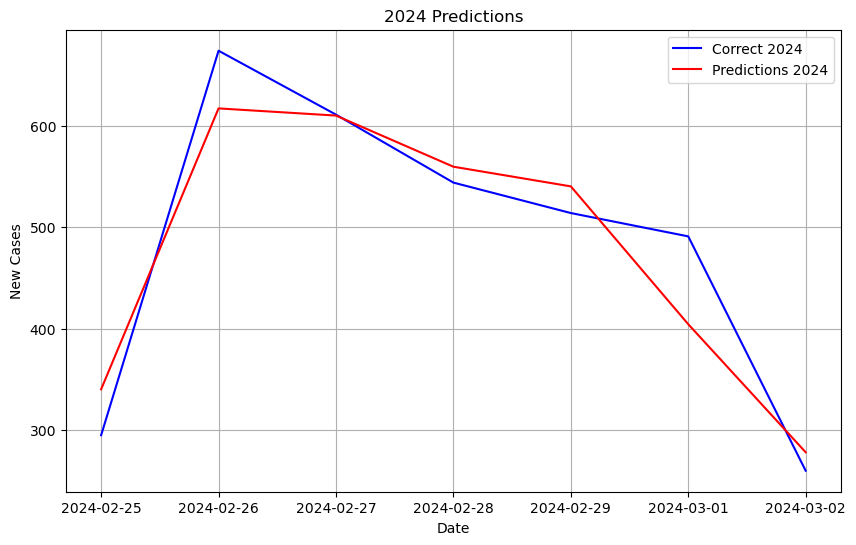

MSE: 2006.7246934441241
MAE: 35.681555784825626
RMSE: 44.7964808153958
Measure error compared to the scale of actual values : 7.370046931064603
2006.7246934441241 35.681555784825626 44.7964808153958 7.370046931064603


In [9]:
# start_date = pd.Timestamp('2024-02-25')
# end_date = start_date + timedelta(days=6)

mse, mae, rmse, error_percentage = analyse_pred(df_combined, predictions, start_date, end_date, var_to_pred='New Cases')
print(mse, mae, rmse, error_percentage)

# New Cases: Dynamic Updating of ARIMA

In [10]:
# only putting this here in case i need to clear input
df_combined = pd.read_csv('data/2022-2024_Stats.csv')

In [11]:
open_balance_input = input("Enter today's Open Balance: ")
close_balance_input = input("Enter today's Close Balance: ")
new_balance_input = input("Enter today's New Balance: ")

try:
    open_balance = float(open_balance_input)
    close_balance = float(close_balance_input)
    new_balance = float(new_balance_input)
except ValueError:
    print("Error: Please enter valid numbers for balances.")
else:
    new_data = {'Date': start_date,
                'Open Balances': open_balance,
                'Closed': close_balance,
                'New Cases': new_balance
                }
    df_combined = df_combined.append(new_data, ignore_index=True)
    print("Values successfully added to DataFrame.")
    print(df_combined[-7:])

Enter today's Open Balance: 56
Enter today's Close Balance: 77
Enter today's New Balance: 77
Values successfully added to DataFrame.
           Date  Open Balances  Closed  New Cases
809  2024-03-20         2737.0   410.0      390.0
810  2024-03-21         2521.0   429.0      428.0
811  2024-03-22         2499.0   432.0      406.0
812  2024-03-23         2473.0    11.0      211.0
813  2024-03-24         2673.0     0.0      214.0
814  2024-03-25         2737.0   466.0      445.0
815  2024-02-25           56.0    77.0       77.0


/var/folders/9d/9y37blc53yz64mgqtz66xrrw0000gp/T/ipykernel_9563/3523237150.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(new_data, ignore_index=True)


In [ ]:
# # Initialize an empty list to store predictions for 2024
predictions_2024 = []

# Number of time steps to forecast for each update
num_steps_2024 = 7

combined_train_data = df_2022_2024_testing['New Cases']
history = combined_train_data.tolist()

if len(combined_train_data) >= 90:

    history.pop(0)  # Remove the oldest value from history
    combined_train_data.pop(0) # Remove the oldest value from combined_train_data
    df_2022_2024_testing = df_2022_2024_testing.drop(df_2022_2024_testing.index[0])

# Make predictions for the next 7 days
for i in range(num_steps_2024):
    # Fit ARIMA model with seasonal differencing
    model = ARIMA(history, order=(7,1,2)) # 7, 1, 0 is the best combination
    model_fit = model.fit()

    # Forecast the next value
    yhat = model_fit.forecast()[0]
    # Append the forecasted value to predictions
    predictions_2024.append(yhat)

    # Update the history with the forecasted value
    history.append(yhat)


#combined_train_data.pop(0)

# Now predictions_2024 contains the predicted values for 2024
print(len(combined_train_data))
print(predictions_2024)

In [ ]:
def dynamic_forecast(train_days, num_steps, p, d, q, var_to_pred):
    # Extract the 'Open Balances' column
    combined_train_data = train_days[var_to_pred]

    # Initialize history with combined training data
    history = [x for x in combined_train_data]
    #print(history, type(p))

    predictions = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        predictions.append(yhat)

        # Update the history with the forecasted value
        history.append(yhat)

    # Now predictions_2024 contains the predicted values for 2024
    print(predictions)
    return predictions


In [ ]:
print(len(history))
print(history)

In [ ]:
# start_date_2024 = pd.Timestamp.today().date()
# print(start_date_2024)
combined_train_data
df_2022_2024_testing

In [ ]:
from datetime import timedelta

# turn dataframe back into date index
today_date = pd.to_datetime('2024-03-26')

# 90 days prior
start_historical_date = today_date - timedelta(days=89)
# date range for 90 days
historical_date_range = pd.date_range(start=start_historical_date, end=today_date, freq='D')
print(len(historical_date_range))
# make date the index
df_2022_2024_testing.index = historical_date_range

df_2022_2024_testing

In [ ]:
# Sample data for filtered_values
filtered_values = df_2022_2024_testing['New Cases'][-1:]

# Calculate the start and end dates for predictions
pred_start_date = pd.Timestamp('2024-03-27')
pred_end_date = pred_start_date + pd.Timedelta(days=6)
time_index_2024 = pd.date_range(start=pred_start_date, end=pred_end_date, freq='D')

# Plotting
plt.figure(figsize=(10, 6))

# Plot filtered_values as a bar plot
plt.bar(df_2022_2024_testing.index[-1:], filtered_values, label='Correct 2024', color='blue')

# Plot predicted values for 2024 as a line plot
plt.plot(time_index_2024, predictions_2024, marker='x', label='Predictions 2024', color='red')

plt.title('2024 Predictions')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.grid(True)
plt.show()

# Closed Cases: Dynamic Updating of Simulation

# Open Balance: Dynamic Updating of Simulation